In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import datetime as dt
import yfinance as yf
from os import path
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
stock = "HPG.VN"
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2024, 1, 1)
df = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df = df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,HPG.VN,HPG.VN,HPG.VN,HPG.VN,HPG.VN
0,2010-01-04,2455.635986,2455.635986,2415.379639,2415.379639,14981968
1,2010-01-05,2576.405029,2576.405029,2455.635986,2576.405029,29885458
2,2010-01-06,2656.917725,2656.917725,2536.148682,2556.276855,44009443
3,2010-01-07,2737.430420,2777.686768,2656.917725,2697.174072,38150498
4,2010-01-08,2616.661377,2797.814941,2616.661377,2797.814941,22580516


In [4]:
data_train = df[['Close']].values

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

data_training = scaler.fit_transform(data_train)

x_train, y_train = [], []
no_of_sample = len(data_train)

In [6]:
for i in range(60, no_of_sample):
    x_train.append(data_training[i-60:i, 0])
    y_train.append(data_training[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

C:\Users\This PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
if path.exists("stock_future.keras"):
    model.load_weights("stock_future.keras")
else:
    model.fit(x_train, y_train, epochs = 100, batch_size = 32)
    model.save("stock_future.keras")

C:\Users\This PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# tap test lay trong khoang tu thang 2/2024 toi thoi diem hien tai
stock = "HPG.VN"
start = dt.datetime(2024, 2, 1)
end = dt.datetime.today()
real_data_price = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [10]:
real_stock_price = real_data_price[['Close']].values

In [11]:
data_total = pd.concat((df['Close'], real_data_price['Close']), axis = 0)
inputs= data_total[len(data_total) - len(real_data_price) - 60:].values
inputs = np.clip(inputs, df['Close'].min(), df['Close'].max())
inputs= inputs.reshape(-1,1)
inputs = scaler.transform(inputs)


In [12]:
x_test = []
no_of_sample = len(inputs)

In [13]:
for i in range(60, no_of_sample):
    x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


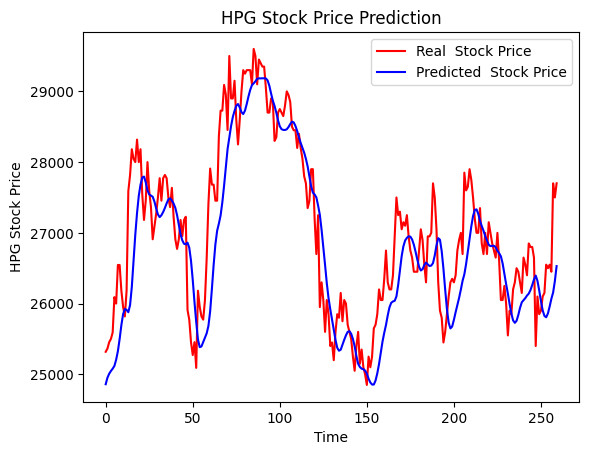

In [14]:
plt.plot(real_stock_price, color = 'red', label = 'Real  Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted  Stock Price')
plt.title('HPG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HPG Stock Price')
plt.legend()
plt.show()

In [ ]:
# du doan trong 1 thang tiep theo
# nghia la tu bay gio den 24/03/2025


# lay 60 ngay cua tap test de tinh cac ngay tiep theo 
real_data_price = real_data_price['Close'][len(real_data_price)-60:len(real_data_price)].to_numpy()
real_data_price = np.array(real_data_price)

In [ ]:
inputs = real_data_price
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [ ]:
i=0
while i<28:
    x_test = []
    no_of_sample = len(real_data_price)

    #lay du lieu cuoi
    x_test.append(inputs[no_of_sample - 60:no_of_sample, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    #du doan
    predicted_stock_price = model.predict(x_test)
    #chuyen du lieu tu 0 1 thanh gia that
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    real_data_price = np.append(real_data_price, predicted_stock_price[0], axis=0)
    inputs = real_data_price
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    
    print('Stock price ' + str(i+3) + f'/2/2025 of {stock} : ', predicted_stock_price[0][0])
    i = i +1